In [ ]:
# GOOGLE COLAB: EXECUTE THIS CELL
! pip install lammps -q
! pip install git+https://github.com/henriasv/lammps-logfile.git

In [1]:
# EXECUTE THIS CELL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
import lammps_logfile
from lammps import lammps

# Exercise 5.1: Tensile strength test of Al

In this exercise, you will perform simulations using the widely adopted molecular dynamics (MD) software **LAMMPS**. For more information, visit the [LAMMPS homepage](http://lammps.sandia.gov).

> **For this task, no Python knowledge is required, but you will need to modify some provided code snippets as instructed.**

> Simulations may take several minutes to complete. Just be patient.

Molecular dynamics (MD) simulations allow us to observe how materials respond to mechanical loading at the atomic scale.
In this exercise, you will study the elastic and plastic behavior of single-crystal aluminum under uniaxial tension using MD.
You will simulate an ideal, defect-free single crystal and extract the stress-strain response during deformation.

Specifically, you will:

- Perform a tensile loading simulation on single-crystal aluminum using an embedded-atom method (EAM) potential,

- Extract and plot the uniaxial stress-strain curve from the output data,

- Determine the elastic modulus of aluminum from the simulation,

- Discuss the limitations of MD-based mechanical testing.

<div style="text-align: center;">
  <img src="Al_tensile.gif" style="width: 500px;">
  <img src="Al_dislocations.gif" style="width: 500px;">
</div>

## (a) Running the simulation

- Begin by copying the file `Al99.eam.alloy` into your working directory.

- Review the code snippet provided for generating the LAMMPS input file. This snippet will create a file named `Al_tensile.in` in your working directory. Take a moment to understand the simulation setup and parameters:

  - A $10 \times 10 \times 10$ FCC unit cell block of aluminum is created using a lattice parameter of 4.05 Å and periodic boundaries in all directions.

  - Potential: An EAM potential for aluminum (`Al99.eam.alloy`) models atomic interactions.

  - The system is equilibrated at 300 K using a Nose-Hoover thermostat and barostat (`fix npt`).

  - The crystal is stretched along the $x$-direction at a high strain rate of $10^{10} \, \text{s}^{-1}$ using `fix deform`, while maintaining constant pressure in the $y$ and $z$ directions.

  - During deformation, the script computes:
  
    - the strain from the change in box length,
  
    - the stress from the virial stress tensor (`pxx`, `pyy`, `pzz`), converted to GPa. These values are printed to a file (`Al_tensile.txt`) every 1000 timesteps.

  - Atomic configuration dumps: Atomic snapshots are saved in `.cfg` format for visualization in tools like OVITO.

- Execute the cell to create the LAMMPS input.

- Execute the cell below the input script to run the simulation. It might take a bit — perfect time to grab a coffee.
  > If you experienced issues running a local version of LAMMPS last time, don't worry: you can switch to **Google Colab**, where everything is preconfigured and should run out of the box. No installation or setup required.

In [2]:
%%writefile Al_tensile.in
######################################
# LAMMPS INPUT SCRIPT
# Input file for uniaxial tensile loading of single crystal aluminum
# Mark Tschopp
# To execute, use the syntax "lmp_exe < in.tensile.txt" from command prompt

######################################
# VARIABLES
variable seed equal 42 
variable n_iter equal 20000

######################################
# INITIALIZATION
units metal
dimension 3
boundary p p p
atom_style atomic
variable latparam equal 4.05

######################################
# ATOM DEFINITION
lattice  fcc ${latparam} orient x 1 0 0 orient y 0 1 0 orient z 0 0 1
region whole block 0 10 0 10 0 10
create_box 1 whole
create_atoms 1 region whole

######################################
# DEFINE INTERATOMIC POTENTIAL
pair_style eam/alloy
pair_coeff * * Al99.eam.alloy Al

######################################
# DEFINE COMPUTES 
compute csym all centro/atom fcc
compute peratom all pe/atom 

######################################
# EQUILIBRATION
reset_timestep 0
timestep 0.001
velocity all create 300 ${seed} mom yes rot no
fix 1 all npt temp 300 300 1 iso 0 0 1 drag 1 

# Set thermo output
thermo 1000
thermo_style custom step lx ly lz press pxx pyy pzz pe temp

# Run for at least 10 picosecond (assuming 1 fs timestep)
run 10000
unfix 1

# Store final cell length for strain calculations
variable tmp equal "lx"
variable L0 equal ${tmp}
print "Initial Length, L0: ${L0}"

######################################
# DEFORMATION
reset_timestep 0

fix 1 all npt temp 300 300 1 y 0 0 1 z 0 0 1 drag 1
variable srate equal 1.0e10
variable srate1 equal "v_srate / 1.0e12"
fix 2 all deform 1 x erate ${srate1} units box remap x

# Output strain and stress info to file
# for units metal, pressure is in [bars] = 100 [kPa] = 1/10000 [GPa]
# p2, p3, p4 are in GPa
variable strain equal "(lx - v_L0)/v_L0"
variable p1 equal "v_strain"
variable p2 equal "-pxx/10000"
variable p3 equal "-pyy/10000"
variable p4 equal "-pzz/10000"
fix def1 all print 100 "${p1} ${p2} ${p3} ${p4}" file Al_tensile.txt screen no

# Use cfg 
dump 1 all cfg 250 dump.tens_*.cfg mass type xs ys zs c_csym c_peratom fx fy fz
dump_modify 1 element Al

# Display thermo
thermo 1000
thermo_style custom step v_strain temp v_p2 v_p3 v_p4 ke pe press
run 20000

######################################
# SIMULATION DONE
print "All done"

Writing Al_tensile.in


In [3]:
# EXECUTE THIS CELL
lmp = lammps(cmdargs=["-log", "Al_tensile.log"])
lmp.file("Al_tensile.in")

LAMMPS (29 Aug 2024 - Update 1)
Lattice spacing in x,y,z = 4.05 4.05 4.05
Created orthogonal box = (0 0 0) to (40.5 40.5 40.5)
  1 by 1 by 1 MPI processor grid
Created 4000 atoms
  using lattice units in orthogonal box = (0 0 0) to (40.5 40.5 40.5)
  create_atoms CPU = 0.001 seconds
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 8.28721
  ghost atom cutoff = 8.28721
  binsize = 4.143605, bins = 10 10 10
  2 neighbor lists, perpetual/occasional/extra = 1 1 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
  (2) compute centro/atom, occasional
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory all

#### Understanding the output

You can open `Al_tensile.txt` within Jupyter and see that it’s not in the most user-friendly format.

Let’s turn it into a tidy DataFrame by running the next cell:

In [4]:
# EXECUTE THIS CELL
# Define column names
columns = ['strain', 'stress_xx (GPa)', 'stress_yy (GPa)', 'stress_zz (GPa)']

# Load data while skipping the comment line
df = pd.read_csv('Al_tensile.txt', 
                 sep='\s+', 
                 comment='#', 
                 names=columns)

df.round(3)

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yr/cvypfzc11jsc27lfvbp3d66w0000gn/T/ipykernel_8049/2812598357.py:7: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


,strain,stress_xx (GPa),stress_yy (GPa),stress_zz (GPa)
0,-0.000,-0.006,0.000,0.002
1,0.001,0.061,-0.001,0.020
2,0.002,0.089,-0.011,-0.025
3,0.003,0.193,-0.011,0.016
4,0.004,0.259,-0.028,0.027
...,...,...,...,...
196,0.196,1.346,0.035,0.051
197,0.197,1.276,-0.057,-0.084
198,0.198,1.320,0.011,0.041
199,0.199,1.195,-0.056,-0.001


## (b) Stress-Strain curve

Although you're only actively deforming the system along the $x$-direction, stress may also develop in the $y$ and $z$ directions due to Poisson effects and thermal fluctuations. Plotting all three components — $\sigma_{xx}$, $\sigma_{yy}$, and $\sigma_{zz}$ — gives you a complete picture of the system’s response.

In the following snippet, you’ll use Seaborn to plot stress versus strain. 

- Replace `header of the x column` and `header of the y column` so that each stress component is plotted against strain on the same graph. You will need to do this three times: once for every stress component.

    > The names of the quantities to be plotted (inside quotation marks) should match exactly the headers of the DataFrame we created in the previous cell, including capitalization, spacing, and units. 

- Use the `label` command to differentiate each curve in the legend.

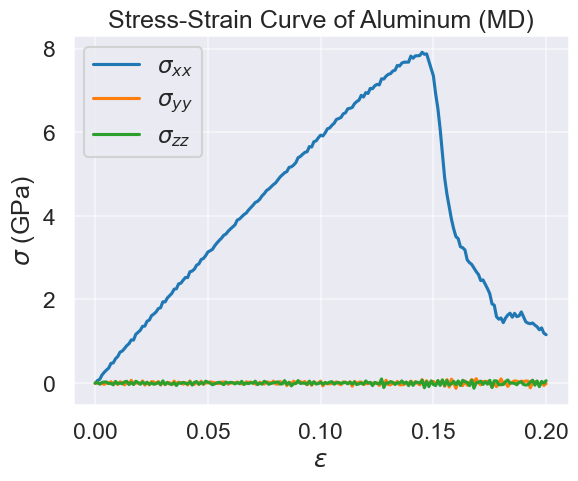

In [5]:
# COMPLETE AND EXECUTE THIS CELL
sns.lineplot(data=df, x='strain', y='stress_xx (GPa)', label=r'$\sigma_{xx}$')
sns.lineplot(data=df, x='strain', y='stress_yy (GPa)', label=r'$\sigma_{yy}$')
sns.lineplot(data=df, x='strain', y='stress_zz (GPa)', label=r'$\sigma_{zz}$')

plt.xlabel(r'$\varepsilon$')  # strain
plt.ylabel(r'$\sigma$ (GPa)')  # stress
plt.title("Stress-Strain Curve of Aluminum (MD)")

plt.grid(alpha=0.5)
plt.legend()
plt.show()

## (c) Calculation of the elastic modulus

To estimate the elastic modulus of aluminum, we take advantage of the fact that, in the elastic regime, stress and strain are linearly related by Hooke’s law:

$$
\sigma = E \cdot \varepsilon
$$

In the next snippet, you’ll extract the stress and strain values from the DataFrame and perform a simple linear fit to the first few points — which correspond to the earliest (and most linear) part of the stress-strain curve.

Specifically, this code selects the first `N` data points from the curve, fits a straight line through those points using `np.polyfit`, interprets the slope of that line as the elastic modulus $E$, measured in GPa.

- Replace `header of the strain column` and `header of the stress column` so that you are fitting the relevant stress component against the strain.

- What happens if you increase `N`? Try changing it to 10, 50, 100, or more: does $E$ stay constant?

- Why is the elastic modulus most accurate at low strain?

- How does your computed $E$ compare with experimental values for aluminum? Can you identify potential reasons for discrepancy?

- What drives plastic deformation in metals? Interpret the stress-strain curve in light of the provided animation.

In [6]:
# COMPLETE AND EXECUTE THIS CELL

# Use stress_xx for uniaxial tension
strain = df['strain'].values
stress = df['stress_xx (GPa)'].values

# Use first N points for linear elastic fit
N = 30  # I can try 10, 30, 50, 100 later to compare but I dont have the time rn
slope, intercept = np.polyfit(strain[:N], stress[:N], 1)
E = slope  # Slope = Elastic Modulus

print(f"Elastic Modulus E ≈ {E:.2f} GPa")

Elastic Modulus E ≈ 63.49 GPa


<div style="text-align: center;">
  <img src="Al_tensile.gif" style="width: 500px;">
  <img src="Al_dislocations.gif" style="width: 500px;">
</div>

- sim is roughly 9% off from experimental value of 70.
- but we only have a 10x10x10 cell which is perfectly defect fre